# PharmGKB/ClinPGx Dataset Exploration

This notebook explores the PharmGKB (Pharmacogenomics Knowledge Base) dataset with a focus on:
1. Pharmacogenomic relationships (gene-drug associations)
2. Clinical annotations (toxicity, efficacy, dosage phenotypes)
3. Pathway data for drug mechanisms
4. Adverse drug reaction patterns

**Research Question**: Can we predict adverse or altered drug outcomes by modeling the interaction between drug-affected biological pathways and disease-perturbed pathways using graph representations?

PharmGKB is a comprehensive resource about how genetic variation affects drug response, curating gene-drug-disease relationships with evidence levels.

## 1. Setup & Dependencies

In [1]:
# Install dependencies if needed
%pip install pandas matplotlib seaborn networkx requests tqdm zipfile-deflate64

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for zipfile-deflate64 (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [130 lines of output]
      /private/var/folders/8b/247_9l2j1zjddy4x74jqqhb80000gn/T/pip-build-env-6v8g2lkh/overlay/lib/python3.14/site-packages/setuptools/dist.py:765: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: Apache Software License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              *****************************************************************

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
import requests
from tqdm import tqdm
import os
import zipfile
import glob

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Data directory
DATA_DIR = 'data/pharmgkb'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(f'{DATA_DIR}/pathways', exist_ok=True)

print("Dependencies loaded successfully!")

Dependencies loaded successfully!


## 2. Download PharmGKB Data

PharmGKB provides free downloads of their curated data at https://www.pharmgkb.org/downloads

Key files we need:
- `clinical_annotations.tsv` - Gene-drug-phenotype associations
- `relationships.tsv` - Entity relationships
- `var_drug_ann.tsv` - Variant-drug annotations
- `drug_labels.tsv` - FDA pharmacogenomic labels
- Pathway files

In [3]:
# PharmGKB download URLs
# Note: PharmGKB requires agreeing to terms. Download manually from https://www.pharmgkb.org/downloads
# or use these direct links (may require browser authentication)

PHARMGKB_FILES = {
    'clinical_annotations': 'https://api.pharmgkb.org/v1/download/file/data/clinicalAnnotations.zip',
    'relationships': 'https://api.pharmgkb.org/v1/download/file/data/relationships.zip',
    'var_drug_ann': 'https://api.pharmgkb.org/v1/download/file/data/variantAnnotations.zip',
    'drug_labels': 'https://api.pharmgkb.org/v1/download/file/data/drugLabels.zip',
    'genes': 'https://api.pharmgkb.org/v1/download/file/data/genes.zip',
    'drugs': 'https://api.pharmgkb.org/v1/download/file/data/drugs.zip',
    'phenotypes': 'https://api.pharmgkb.org/v1/download/file/data/phenotypes.zip',
}

def download_pharmgkb_file(name, url, data_dir):
    """Download and extract PharmGKB zip file."""
    zip_path = f"{data_dir}/{name}.zip"
    
    # Check if already extracted
    tsv_files = glob.glob(f"{data_dir}/{name}*.tsv") + glob.glob(f"{data_dir}/*{name}*.tsv")
    if tsv_files:
        print(f"  {name}: Already downloaded ({len(tsv_files)} file(s))")
        return tsv_files
    
    print(f"  Downloading {name}...")
    try:
        response = requests.get(url, stream=True, timeout=60)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        with open(zip_path, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True, desc=name) as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))
        
        # Extract
        print(f"  Extracting {name}...")
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(data_dir)
        
        os.remove(zip_path)
        return glob.glob(f"{data_dir}/*.tsv")
        
    except Exception as e:
        print(f"  Error downloading {name}: {e}")
        print(f"  Please download manually from https://www.pharmgkb.org/downloads")
        return []

print("Downloading PharmGKB datasets...")
print("="*60)
for name, url in PHARMGKB_FILES.items():
    download_pharmgkb_file(name, url, DATA_DIR)
print("="*60)
print("Download complete!")

clinical_annotations: 100%|██████████| 1.23M/1.23M [00:00<00:00, 6.99MB/s]


  Extracting clinical_annotations...


relationships: 100%|██████████| 2.37M/2.37M [00:00<00:00, 9.40MB/s]


  Extracting relationships...


var_drug_ann: 100%|██████████| 4.15M/4.15M [00:00<00:00, 7.45MB/s]


  Extracting var_drug_ann...


drug_labels: 100%|██████████| 56.9k/56.9k [00:00<00:00, 32.2MB/s]


  Extracting drug_labels...


genes: 100%|██████████| 2.91M/2.91M [00:00<00:00, 9.61MB/s]


  Extracting genes...


drugs: 100%|██████████| 669k/669k [00:00<00:00, 8.86MB/s]


  Extracting drugs...


phenotypes: 100%|██████████| 187k/187k [00:00<00:00, 9.34MB/s]

  Extracting phenotypes...
Download complete!


In [4]:
# List downloaded files
print("\nDownloaded files:")
for f in sorted(glob.glob(f"{DATA_DIR}/*.tsv")):
    size_mb = os.path.getsize(f) / 1e6
    print(f"  {os.path.basename(f)}: {size_mb:.2f} MB")


Downloaded files:
  clinical_ann_alleles.tsv: 5.56 MB
  clinical_ann_evidence.tsv: 4.01 MB
  clinical_ann_history.tsv: 1.45 MB
  clinical_annotations.tsv: 0.85 MB
  drugLabels.byGene.tsv: 0.15 MB
  drugLabels.tsv: 0.20 MB
  drugs.tsv: 2.20 MB
  genes.tsv: 11.10 MB
  phenotypes.tsv: 0.86 MB
  relationships.tsv: 15.49 MB
  study_parameters.tsv: 5.53 MB
  var_drug_ann.tsv: 6.95 MB
  var_fa_ann.tsv: 1.08 MB
  var_pheno_ann.tsv: 8.59 MB


In [ ]:
# Alternative: Manual download instructions
print("""
If automatic download fails, manually download from:
https://www.pharmgkb.org/downloads

Required files:
1. Clinical Annotations -> extract to data/pharmgkb/
2. Relationships -> extract to data/pharmgkb/
3. Variant Annotations -> extract to data/pharmgkb/
4. Drug Labels -> extract to data/pharmgkb/
5. Genes -> extract to data/pharmgkb/
6. Drugs -> extract to data/pharmgkb/

For pathways, download individual pathway TSVs to data/pharmgkb/pathways/
""")

## 3. Clinical Annotations Analysis

Clinical annotations are the core of PharmGKB - they link genetic variants to drug response phenotypes with evidence levels.

**Phenotype Categories:**
- Toxicity - adverse effects (key for ADR prediction)
- Dosage - dose adjustments needed
- Efficacy - drug effectiveness
- Metabolism/PK - how body processes drug
- Pharmacodynamics - drug's effect on body

**Evidence Levels:**
- 1A: Highest (FDA label, CPIC guideline)
- 1B: High (strong evidence)
- 2A: Moderate (known PGx)
- 2B: Moderate (fair evidence)
- 3: Low (weak evidence)
- 4: Minimal (in vitro/preliminary)

In [5]:
# Load clinical annotations
clinical_ann_file = glob.glob(f"{DATA_DIR}/clinical_ann*.tsv")
if not clinical_ann_file:
    clinical_ann_file = glob.glob(f"{DATA_DIR}/*clinical*.tsv")

if clinical_ann_file:
    print(f"Loading: {clinical_ann_file[0]}")
    clinical_ann = pd.read_csv(clinical_ann_file[0], sep='\t', low_memory=False)
    print(f"Loaded {len(clinical_ann):,} clinical annotations")
else:
    print("Clinical annotations file not found. Please download from PharmGKB.")
    clinical_ann = pd.DataFrame()

Loading: data/pharmgkb/clinical_ann_history.tsv
Loaded 14,030 clinical annotations


In [6]:
# Explore clinical annotations structure
if len(clinical_ann) > 0:
    print("="*60)
    print("CLINICAL ANNOTATIONS OVERVIEW")
    print("="*60)
    print(f"\nShape: {clinical_ann.shape}")
    print(f"\nColumns: {list(clinical_ann.columns)}")
    print(f"\nData types:")
    print(clinical_ann.dtypes)

CLINICAL ANNOTATIONS OVERVIEW

Shape: (14030, 4)

Columns: ['Clinical Annotation ID', 'Date (YYYY-MM-DD)', 'Type', 'Comment']

Data types:
Clinical Annotation ID    int64
Date (YYYY-MM-DD)           str
Type                        str
Comment                     str
dtype: object


In [7]:
# Sample clinical annotations
if len(clinical_ann) > 0:
    print("\nSample clinical annotations:")
    display(clinical_ann.head(10))


Sample clinical annotations:


,Clinical Annotation ID,Date (YYYY-MM-DD),Type,Comment
0,655384602,2018-11-05,Update,Updated OMB race to appropriate biogeographical group
1,655384602,2021-03-24,Update,CA score added as part of scoring system release. LOE may have automatically changed based on ne...
2,655384607,2018-11-05,Update,Updated OMB race to appropriate biogeographical group
3,655384607,2021-03-24,Update,CA score added as part of scoring system release. LOE may have automatically changed based on ne...
4,655384626,2018-11-05,Update,Updated OMB race to appropriate biogeographical group
5,655384626,2021-03-24,Update,CA score added as part of scoring system release. LOE may have automatically changed based on ne...
6,655384635,2021-03-24,Update,CA score added as part of scoring system release. LOE may have automatically changed based on ne...
7,655384670,2021-03-24,Update,CA score added as part of scoring system release. LOE may have automatically changed based on ne...
8,655384674,2021-03-24,Update,CA score added as part of scoring system release. LOE may have automatically changed based on ne...
9,655384679,2018-11-05,Update,Updated OMB race to appropriate biogeographical group


In [8]:
# Analyze evidence levels
if len(clinical_ann) > 0:
    # Find the evidence level column (may be named differently)
    evidence_col = None
    for col in clinical_ann.columns:
        if 'level' in col.lower() or 'evidence' in col.lower():
            evidence_col = col
            break
    
    if evidence_col:
        print(f"\nEvidence Level Distribution (column: {evidence_col}):")
        evidence_counts = clinical_ann[evidence_col].value_counts().sort_index()
        print(evidence_counts)
        
        # Visualize
        fig, ax = plt.subplots(figsize=(10, 5))
        colors = ['darkgreen', 'green', 'yellowgreen', 'gold', 'orange', 'red']
        bars = ax.bar(evidence_counts.index.astype(str), evidence_counts.values, 
                     color=colors[:len(evidence_counts)])
        ax.set_xlabel('Evidence Level', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_title('Distribution of Evidence Levels in Clinical Annotations', fontsize=14)
        
        for bar, val in zip(bars, evidence_counts.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,}',
                   ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Evidence level column not found. Available columns:")
        print(clinical_ann.columns.tolist())

Evidence level column not found. Available columns:
['Clinical Annotation ID', 'Date (YYYY-MM-DD)', 'Type', 'Comment']


In [9]:
# Analyze phenotype categories
if len(clinical_ann) > 0:
    # Find phenotype-related columns
    phenotype_cols = [col for col in clinical_ann.columns 
                     if 'phenotype' in col.lower() or 'category' in col.lower()]
    
    print("\nPhenotype-related columns:")
    for col in phenotype_cols:
        print(f"\n{col}:")
        print(clinical_ann[col].value_counts().head(20))


Phenotype-related columns:


In [10]:
# Count unique entities in clinical annotations
if len(clinical_ann) > 0:
    print("\nUnique Entities in Clinical Annotations:")
    print("="*60)
    
    # Find gene, drug, variant columns
    for entity in ['gene', 'drug', 'variant', 'chemical']:
        entity_cols = [col for col in clinical_ann.columns if entity in col.lower()]
        for col in entity_cols:
            unique_count = clinical_ann[col].nunique()
            print(f"{col}: {unique_count:,} unique values")


Unique Entities in Clinical Annotations:


In [11]:
# Top genes by annotation count
if len(clinical_ann) > 0:
    gene_col = None
    for col in clinical_ann.columns:
        if 'gene' in col.lower() and 'id' not in col.lower():
            gene_col = col
            break
    
    if gene_col:
        print(f"\nTop 20 genes by clinical annotation count ({gene_col}):")
        gene_counts = clinical_ann[gene_col].value_counts().head(20)
        print(gene_counts)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        gene_counts.plot(kind='bar', ax=ax, color=sns.color_palette('husl', 20))
        ax.set_xlabel('Gene', fontsize=12)
        ax.set_ylabel('Number of Annotations', fontsize=12)
        ax.set_title('Top 20 Genes in PharmGKB Clinical Annotations', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 4. Gene-Drug Relationships

The relationships file contains the network of gene-drug-disease associations.

In [12]:
# Load relationships
rel_file = glob.glob(f"{DATA_DIR}/relationships*.tsv")
if not rel_file:
    rel_file = glob.glob(f"{DATA_DIR}/*relation*.tsv")

if rel_file:
    print(f"Loading: {rel_file[0]}")
    relationships = pd.read_csv(rel_file[0], sep='\t', low_memory=False)
    print(f"Loaded {len(relationships):,} relationships")
else:
    print("Relationships file not found.")
    relationships = pd.DataFrame()

Loading: data/pharmgkb/relationships.tsv
Loaded 127,600 relationships


In [13]:
# Explore relationships structure
if len(relationships) > 0:
    print("="*60)
    print("RELATIONSHIPS OVERVIEW")
    print("="*60)
    print(f"\nShape: {relationships.shape}")
    print(f"\nColumns: {list(relationships.columns)}")
    print(f"\nSample:")
    display(relationships.head(10))

RELATIONSHIPS OVERVIEW

Shape: (127600, 11)

Columns: ['Entity1_id', 'Entity1_name', 'Entity1_type', 'Entity2_id', 'Entity2_name', 'Entity2_type', 'Evidence', 'Association', 'PK', 'PD', 'PMIDs']

Sample:


,Entity1_id,Entity1_name,Entity1_type,Entity2_id,Entity2_name,Entity2_type,Evidence,Association,PK,PD,PMIDs
0,PA31744,NQO1,Gene,PA10384,"antiinflammatory and antirheumatic products, non-steroids",Chemical,VariantAnnotation,not associated,NaN,NaN,17400324
1,PA31744,NQO1,Gene,PA10804,imatinib,Chemical,"ClinicalAnnotation,MultilinkAnnotation,VariantAnnotation",ambiguous,NaN,PD,30237583
2,PA31744,NQO1,Gene,PA10832,corticosteroids,Chemical,VariantAnnotation,not associated,NaN,NaN,26644204
3,PA31744,NQO1,Gene,PA128406956,fluorouracil,Chemical,"ClinicalAnnotation,VariantAnnotation",ambiguous,NaN,PD,18511948;25545243;26014925;39012380
4,PA31744,NQO1,Gene,PA130620651,anthracyclines and related substances,Chemical,VariantAnnotation,not associated,NaN,NaN,18457324
5,PA31744,NQO1,Gene,PA131285527,oxaliplatin,Chemical,"ClinicalAnnotation,Literature,MultilinkAnnotation,VariantAnnotation",ambiguous,NaN,PD,24924344;25545243
6,PA31744,NQO1,Gene,PA143485705,antiepileptics,Chemical,VariantAnnotation,not associated,NaN,NaN,17400324
7,PA31744,NQO1,Gene,PA151958383,Gastrointestinal Stromal Tumors,Disease,"ClinicalAnnotation,VariantAnnotation",associated,NaN,PD,30237583
8,PA31744,NQO1,Gene,PA164712363,Analgesics and anesthetics,Chemical,VariantAnnotation,not associated,NaN,NaN,17400324
9,PA31744,NQO1,Gene,PA164712406,Antibiotics,Chemical,VariantAnnotation,not associated,NaN,NaN,17400324


In [14]:
# Analyze entity types in relationships
if len(relationships) > 0:
    # Find entity type columns
    type_cols = [col for col in relationships.columns if 'type' in col.lower()]
    
    print("\nEntity types in relationships:")
    for col in type_cols:
        print(f"\n{col}:")
        print(relationships[col].value_counts())


Entity types in relationships:

Entity1_type:
Entity1_type
Variant      32797
Chemical     32787
Disease      29293
Gene         23470
Haplotype     9253
Name: count, dtype: int64

Entity2_type:
Entity2_type
Variant      32797
Chemical     32787
Disease      29293
Gene         23470
Haplotype     9253
Name: count, dtype: int64


In [15]:
# Filter gene-drug relationships
if len(relationships) > 0:
    # Try to identify entity type columns
    entity1_type = [col for col in relationships.columns if 'entity1' in col.lower() and 'type' in col.lower()]
    entity2_type = [col for col in relationships.columns if 'entity2' in col.lower() and 'type' in col.lower()]
    
    if entity1_type and entity2_type:
        e1_col, e2_col = entity1_type[0], entity2_type[0]
        
        # Gene-Drug relationships
        gene_drug_mask = (
            ((relationships[e1_col] == 'Gene') & (relationships[e2_col] == 'Chemical')) |
            ((relationships[e1_col] == 'Chemical') & (relationships[e2_col] == 'Gene'))
        )
        gene_drug_rels = relationships[gene_drug_mask]
        
        print(f"\nGene-Drug relationships: {len(gene_drug_rels):,}")
        print(f"\nSample:")
        display(gene_drug_rels.head(10))


Gene-Drug relationships: 21,964

Sample:


,Entity1_id,Entity1_name,Entity1_type,Entity2_id,Entity2_name,Entity2_type,Evidence,Association,PK,PD,PMIDs
0,PA31744,NQO1,Gene,PA10384,"antiinflammatory and antirheumatic products, non-steroids",Chemical,VariantAnnotation,not associated,NaN,NaN,17400324
1,PA31744,NQO1,Gene,PA10804,imatinib,Chemical,"ClinicalAnnotation,MultilinkAnnotation,VariantAnnotation",ambiguous,NaN,PD,30237583
2,PA31744,NQO1,Gene,PA10832,corticosteroids,Chemical,VariantAnnotation,not associated,NaN,NaN,26644204
3,PA31744,NQO1,Gene,PA128406956,fluorouracil,Chemical,"ClinicalAnnotation,VariantAnnotation",ambiguous,NaN,PD,18511948;25545243;26014925;39012380
4,PA31744,NQO1,Gene,PA130620651,anthracyclines and related substances,Chemical,VariantAnnotation,not associated,NaN,NaN,18457324
5,PA31744,NQO1,Gene,PA131285527,oxaliplatin,Chemical,"ClinicalAnnotation,Literature,MultilinkAnnotation,VariantAnnotation",ambiguous,NaN,PD,24924344;25545243
6,PA31744,NQO1,Gene,PA143485705,antiepileptics,Chemical,VariantAnnotation,not associated,NaN,NaN,17400324
8,PA31744,NQO1,Gene,PA164712363,Analgesics and anesthetics,Chemical,VariantAnnotation,not associated,NaN,NaN,17400324
9,PA31744,NQO1,Gene,PA164712406,Antibiotics,Chemical,VariantAnnotation,not associated,NaN,NaN,17400324
10,PA31744,NQO1,Gene,PA164712435,Antifungals For Systemic Use,Chemical,VariantAnnotation,not associated,NaN,NaN,17400324


In [ ]:
# Build gene-drug network statistics
if len(relationships) > 0 and 'gene_drug_rels' in dir() and len(gene_drug_rels) > 0:
    # Find name columns
    name1_col = [col for col in relationships.columns if 'entity1' in col.lower() and 'name' in col.lower()]
    name2_col = [col for col in relationships.columns if 'entity2' in col.lower() and 'name' in col.lower()]
    
    if name1_col and name2_col:
        n1_col, n2_col = name1_col[0], name2_col[0]
        
        # Most connected genes
        gene_mask_1 = gene_drug_rels[e1_col] == 'Gene'
        genes_1 = gene_drug_rels[gene_mask_1][n1_col].value_counts()
        genes_2 = gene_drug_rels[~gene_mask_1][n2_col].value_counts()
        gene_counts = genes_1.add(genes_2, fill_value=0).sort_values(ascending=False)
        
        print("\nTop 20 most connected genes (by drug relationships):")
        print(gene_counts.head(20))
        
        # Most connected drugs
        drug_mask_1 = gene_drug_rels[e1_col] == 'Chemical'
        drugs_1 = gene_drug_rels[drug_mask_1][n1_col].value_counts()
        drugs_2 = gene_drug_rels[~drug_mask_1][n2_col].value_counts()
        drug_counts = drugs_1.add(drugs_2, fill_value=0).sort_values(ascending=False)
        
        print("\nTop 20 most connected drugs (by gene relationships):")
        print(drug_counts.head(20))

In [ ]:
# Visualize relationship type distribution
if len(relationships) > 0:
    # Find association/evidence column
    assoc_col = None
    for col in relationships.columns:
        if 'association' in col.lower() or 'evidence' in col.lower():
            assoc_col = col
            break
    
    if assoc_col:
        print(f"\nRelationship/Association types ({assoc_col}):")
        assoc_counts = relationships[assoc_col].value_counts()
        print(assoc_counts)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        assoc_counts.plot(kind='barh', ax=ax, color=sns.color_palette('husl', len(assoc_counts)))
        ax.set_xlabel('Count', fontsize=12)
        ax.set_ylabel('Association Type', fontsize=12)
        ax.set_title('Distribution of Relationship Types in PharmGKB', fontsize=14)
        plt.tight_layout()
        plt.show()

## 5. Build PharmGKB Knowledge Graph

Transform the relationships data into a PrimeKG-compatible knowledge graph format for unified analysis and GNN modeling.

**Goals:**
- Convert to standardized KG format (x_type, y_type, relation)
- Build NetworkX graph for analysis
- Compute graph statistics comparable to PrimeKG
- Export for GNN integration

### 5.1 Convert to PrimeKG-Compatible Format

Map PharmGKB entities and relationships to standardized schema.

In [36]:
# Define entity type mapping (PharmGKB -> PrimeKG compatible)
TYPE_MAPPING = {
    'Chemical': 'drug',
    'Gene': 'gene/protein',
    'Disease': 'disease',
    'Variant': 'variant',
    'Haplotype': 'haplotype'
}

def derive_relation_type(row):
    """Derive detailed relation type from Association + PK/PD columns."""
    assoc = str(row.get('Association', '')).lower()
    pk = row.get('PK', '')
    pd_val = row.get('PD', '')
    
    # Check for PK/PD annotations
    has_pk = pd.notna(pk) and str(pk).strip() != ''
    has_pd = pd.notna(pd_val) and str(pd_val).strip() != ''
    
    if assoc == 'associated':
        if has_pk and has_pd:
            return 'pk_pd_association'
        elif has_pk:
            return 'pharmacokinetic_association'
        elif has_pd:
            return 'pharmacodynamic_association'
        else:
            return 'associated'
    elif assoc == 'not associated':
        return 'no_association'
    elif assoc == 'ambiguous':
        return 'ambiguous_association'
    else:
        return 'unknown_association'

print("Entity type mapping:")
for k, v in TYPE_MAPPING.items():
    print(f"  {k} -> {v}")

Entity type mapping:
  Chemical -> drug
  Gene -> gene/protein
  Disease -> disease
  Variant -> variant
  Haplotype -> haplotype


In [37]:
# Convert relationships to PrimeKG-compatible format
if len(relationships) > 0:
    print("Converting PharmGKB relationships to Knowledge Graph format...")
    print("="*60)
    
    # Create KG dataframe
    pharmgkb_kg = pd.DataFrame({
        'x_id': relationships['Entity1_id'],
        'x_name': relationships['Entity1_name'],
        'x_type': relationships['Entity1_type'].map(TYPE_MAPPING),
        'y_id': relationships['Entity2_id'],
        'y_name': relationships['Entity2_name'],
        'y_type': relationships['Entity2_type'].map(TYPE_MAPPING),
        'relation': relationships.apply(derive_relation_type, axis=1),
        'evidence': relationships['Evidence'],
        'pmids': relationships['PMIDs'],
        'source': 'PharmGKB'
    })
    
    print(f"\nKnowledge Graph created:")
    print(f"  Total edges: {len(pharmgkb_kg):,}")
    print(f"  Columns: {list(pharmgkb_kg.columns)}")
    
    print(f"\nSample edges:")
    display(pharmgkb_kg.head(10))

Converting PharmGKB relationships to Knowledge Graph format...

Knowledge Graph created:
  Total edges: 127,600
  Columns: ['x_id', 'x_name', 'x_type', 'y_id', 'y_name', 'y_type', 'relation', 'evidence', 'pmids', 'source']

Sample edges:


,x_id,x_name,x_type,y_id,y_name,y_type,relation,evidence,pmids,source
0,PA31744,NQO1,gene/protein,PA10384,"antiinflammatory and antirheumatic products, non-steroids",drug,no_association,VariantAnnotation,17400324,PharmGKB
1,PA31744,NQO1,gene/protein,PA10804,imatinib,drug,ambiguous_association,"ClinicalAnnotation,MultilinkAnnotation,VariantAnnotation",30237583,PharmGKB
2,PA31744,NQO1,gene/protein,PA10832,corticosteroids,drug,no_association,VariantAnnotation,26644204,PharmGKB
3,PA31744,NQO1,gene/protein,PA128406956,fluorouracil,drug,ambiguous_association,"ClinicalAnnotation,VariantAnnotation",18511948;25545243;26014925;39012380,PharmGKB
4,PA31744,NQO1,gene/protein,PA130620651,anthracyclines and related substances,drug,no_association,VariantAnnotation,18457324,PharmGKB
5,PA31744,NQO1,gene/protein,PA131285527,oxaliplatin,drug,ambiguous_association,"ClinicalAnnotation,Literature,MultilinkAnnotation,VariantAnnotation",24924344;25545243,PharmGKB
6,PA31744,NQO1,gene/protein,PA143485705,antiepileptics,drug,no_association,VariantAnnotation,17400324,PharmGKB
7,PA31744,NQO1,gene/protein,PA151958383,Gastrointestinal Stromal Tumors,disease,pharmacodynamic_association,"ClinicalAnnotation,VariantAnnotation",30237583,PharmGKB
8,PA31744,NQO1,gene/protein,PA164712363,Analgesics and anesthetics,drug,no_association,VariantAnnotation,17400324,PharmGKB
9,PA31744,NQO1,gene/protein,PA164712406,Antibiotics,drug,no_association,VariantAnnotation,17400324,PharmGKB


In [38]:
# Analyze KG structure
if 'pharmgkb_kg' in dir():
    print("\n" + "="*60)
    print("KNOWLEDGE GRAPH STRUCTURE ANALYSIS")
    print("="*60)
    
    # Node type distribution
    x_types = pharmgkb_kg['x_type'].value_counts()
    y_types = pharmgkb_kg['y_type'].value_counts()
    
    print("\nSource node types (x_type):")
    print(x_types)
    
    print("\nTarget node types (y_type):")
    print(y_types)
    
    # Relation type distribution
    print("\nRelation type distribution:")
    relation_counts = pharmgkb_kg['relation'].value_counts()
    print(relation_counts)


KNOWLEDGE GRAPH STRUCTURE ANALYSIS

Source node types (x_type):
x_type
variant         32797
drug            32787
disease         29293
gene/protein    23470
haplotype        9253
Name: count, dtype: int64

Target node types (y_type):
y_type
variant         32797
drug            32787
disease         29293
gene/protein    23470
haplotype        9253
Name: count, dtype: int64

Relation type distribution:
relation
associated                     51910
no_association                 33098
pharmacodynamic_association    22560
ambiguous_association          20032
Name: count, dtype: int64


### 5.2 Build NetworkX Graph

Create a heterogeneous graph with typed nodes and edges for graph analysis.

In [39]:
# Build NetworkX graph from KG
if 'pharmgkb_kg' in dir():
    print("Building NetworkX graph...")
    
    G = nx.Graph()  # Undirected graph (most KG analyses treat edges as undirected)
    
    # Add edges with attributes
    for _, row in tqdm(pharmgkb_kg.iterrows(), total=len(pharmgkb_kg), desc="Adding edges"):
        # Create unique node identifiers
        x_node = f"{row['x_type']}::{row['x_id']}"
        y_node = f"{row['y_type']}::{row['y_id']}"
        
        # Add nodes with attributes
        G.add_node(x_node, 
                   node_id=row['x_id'],
                   name=row['x_name'], 
                   node_type=row['x_type'])
        G.add_node(y_node,
                   node_id=row['y_id'],
                   name=row['y_name'],
                   node_type=row['y_type'])
        
        # Add edge with attributes
        G.add_edge(x_node, y_node,
                   relation=row['relation'],
                   evidence=row['evidence'],
                   source='PharmGKB')
    
    print(f"\nNetworkX graph built:")
    print(f"  Nodes: {G.number_of_nodes():,}")
    print(f"  Edges: {G.number_of_edges():,}")

Building NetworkX graph...


Adding edges: 100%|██████████| 127600/127600 [00:05<00:00, 24877.67it/s]


NetworkX graph built:
  Nodes: 12,528
  Edges: 63,800


### 5.3 Graph Statistics

Compute statistics comparable to PrimeKG analysis.

In [40]:
# Compute comprehensive graph statistics
if 'G' in dir():
    print("="*60)
    print("PHARMGKB KNOWLEDGE GRAPH STATISTICS")
    print("="*60)
    
    # Basic stats
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    print(f"\nBasic Statistics:")
    print(f"  Total nodes: {num_nodes:,}")
    print(f"  Total edges: {num_edges:,}")
    
    # Density
    density = nx.density(G)
    print(f"  Graph density: {density:.6f}")
    
    # Average degree
    degrees = [d for n, d in G.degree()]
    avg_degree = np.mean(degrees)
    print(f"  Average degree: {avg_degree:.2f}")
    print(f"  Max degree: {max(degrees):,}")
    print(f"  Min degree: {min(degrees)}")
    print(f"  Median degree: {np.median(degrees):.0f}")
    
    # Connected components
    num_components = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)
    print(f"  Connected components: {num_components:,}")
    print(f"  Largest component size: {len(largest_cc):,} ({100*len(largest_cc)/num_nodes:.1f}%)")

PHARMGKB KNOWLEDGE GRAPH STATISTICS

Basic Statistics:
  Total nodes: 12,528
  Total edges: 63,800
  Graph density: 0.000813
  Average degree: 10.19
  Max degree: 704
  Min degree: 1
  Median degree: 3
  Connected components: 36
  Largest component size: 12,390 (98.9%)


In [41]:
# Node type distribution
if 'G' in dir():
    node_types = {}
    for node, data in G.nodes(data=True):
        ntype = data.get('node_type', 'unknown')
        node_types[ntype] = node_types.get(ntype, 0) + 1
    
    node_type_df = pd.DataFrame([
        {'Node Type': k, 'Count': v} for k, v in node_types.items()
    ]).sort_values('Count', ascending=False)
    
    print("\nNode Type Distribution:")
    print(node_type_df.to_string(index=False))
    print(f"\nTotal unique nodes: {sum(node_types.values()):,}")


Node Type Distribution:
   Node Type  Count
     variant   7159
gene/protein   2498
        drug   1471
     disease    761
   haplotype    639

Total unique nodes: 12,528


In [42]:
# Most connected nodes by type
if 'G' in dir():
    print("\nMost Connected Nodes by Type:")
    print("="*60)
    
    # Group nodes by type and compute degrees
    node_degrees_by_type = {}
    for node, degree in G.degree():
        ntype = G.nodes[node].get('node_type', 'unknown')
        name = G.nodes[node].get('name', node)
        if ntype not in node_degrees_by_type:
            node_degrees_by_type[ntype] = []
        node_degrees_by_type[ntype].append((name, degree))
    
    # Show top 5 for each type
    for ntype in sorted(node_degrees_by_type.keys()):
        nodes = sorted(node_degrees_by_type[ntype], key=lambda x: x[1], reverse=True)[:5]
        print(f"\n{ntype.upper()}:")
        for name, degree in nodes:
            # Truncate long names
            display_name = name[:40] + "..." if len(str(name)) > 40 else name
            print(f"  {display_name}: {degree} connections")


Most Connected Nodes by Type:

DISEASE:
  Breast Neoplasms: 704 connections
  Schizophrenia: 698 connections
  Neoplasms: 697 connections
  Drug Toxicity: 681 connections
  Acute lymphoblastic leukemia: 537 connections

DRUG:
  fluorouracil: 672 connections
  methotrexate: 493 connections
  cisplatin: 374 connections
  cyclophosphamide: 370 connections
  capecitabine: 367 connections

GENE/PROTEIN:
  ABCB1: 447 connections
  CYP2D6: 440 connections
  CYP2C19: 365 connections
  CYP3A4: 348 connections
  CYP3A5: 322 connections

HAPLOTYPE:
  CYP2C19*1: 238 connections
  CYP2D6*1: 216 connections
  CYP2C19*2: 214 connections
  CYP2D6*4: 203 connections
  CYP3A5*3: 201 connections

VARIANT:
  rs1045642: 372 connections
  rs2032582: 246 connections
  rs1128503: 199 connections
  rs776746: 168 connections
  rs1801133: 154 connections


### 5.4 Graph Visualizations

Visualize the knowledge graph structure.

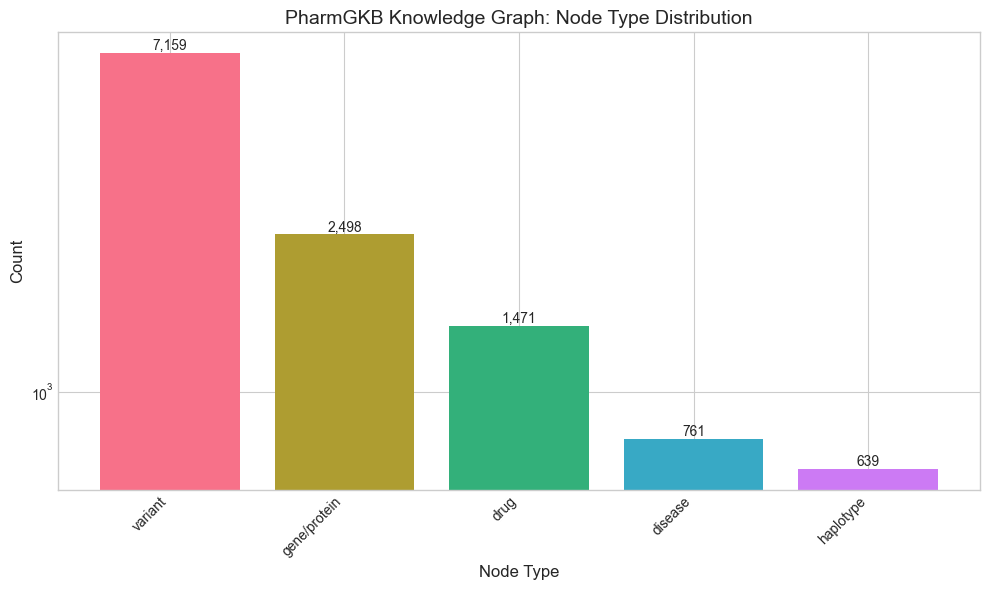

In [43]:
# Visualize node type distribution
if 'node_type_df' in dir():
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette('husl', len(node_type_df))
    bars = ax.bar(node_type_df['Node Type'], node_type_df['Count'], color=colors)
    ax.set_xlabel('Node Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('PharmGKB Knowledge Graph: Node Type Distribution', fontsize=14)
    ax.set_yscale('log')
    
    for bar, count in zip(bars, node_type_df['Count']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}',
               ha='center', va='bottom', fontsize=10)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

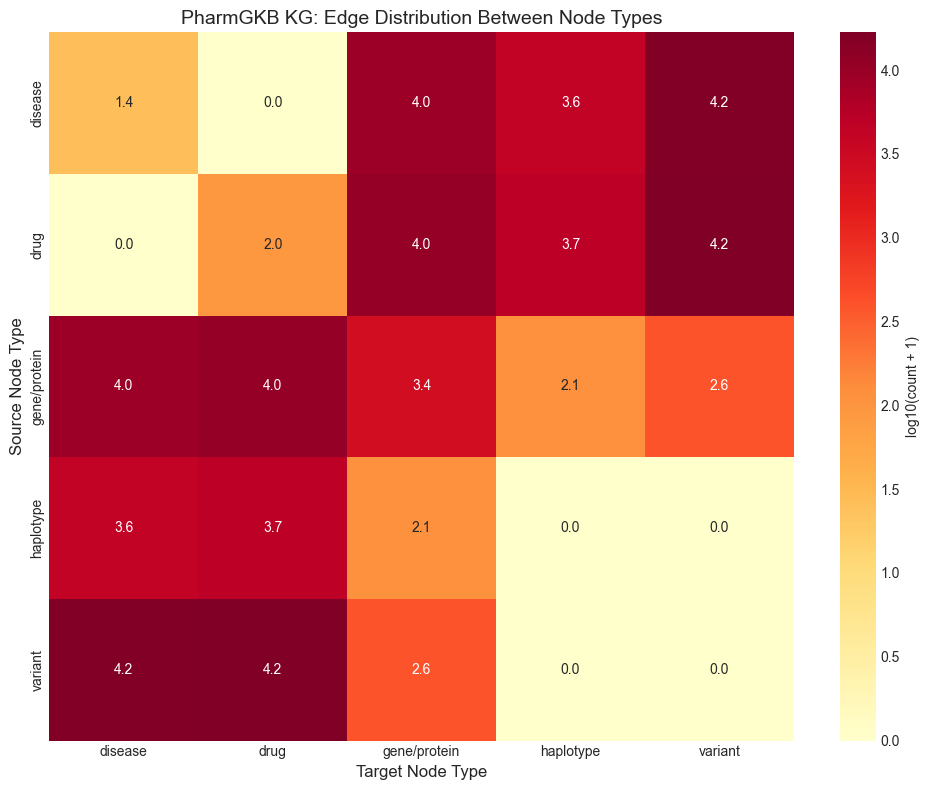


Edge counts between node types:
              disease   drug  gene/protein  haplotype  variant
disease            26      0          9432       4213    15622
drug                0     94         10982       4928    16783
gene/protein     9432  10982          2552        112      392
haplotype        4213   4928           112          0        0
variant         15622  16783           392          0        0


In [44]:
# Edge type heatmap (source_type -> target_type)
if 'pharmgkb_kg' in dir():
    # Count edges between node type pairs
    edge_type_pairs = pharmgkb_kg.groupby(['x_type', 'y_type']).size().reset_index(name='count')
    
    # Create pivot table
    all_types = sorted(set(pharmgkb_kg['x_type'].unique()) | set(pharmgkb_kg['y_type'].unique()))
    edge_matrix = pd.DataFrame(0, index=all_types, columns=all_types)
    
    for _, row in edge_type_pairs.iterrows():
        edge_matrix.loc[row['x_type'], row['y_type']] = row['count']
    
    # Log transform for visualization
    edge_matrix_log = np.log10(edge_matrix + 1)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(edge_matrix_log, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
               cbar_kws={'label': 'log10(count + 1)'})
    ax.set_xlabel('Target Node Type', fontsize=12)
    ax.set_ylabel('Source Node Type', fontsize=12)
    ax.set_title('PharmGKB KG: Edge Distribution Between Node Types', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nEdge counts between node types:")
    print(edge_matrix.to_string())

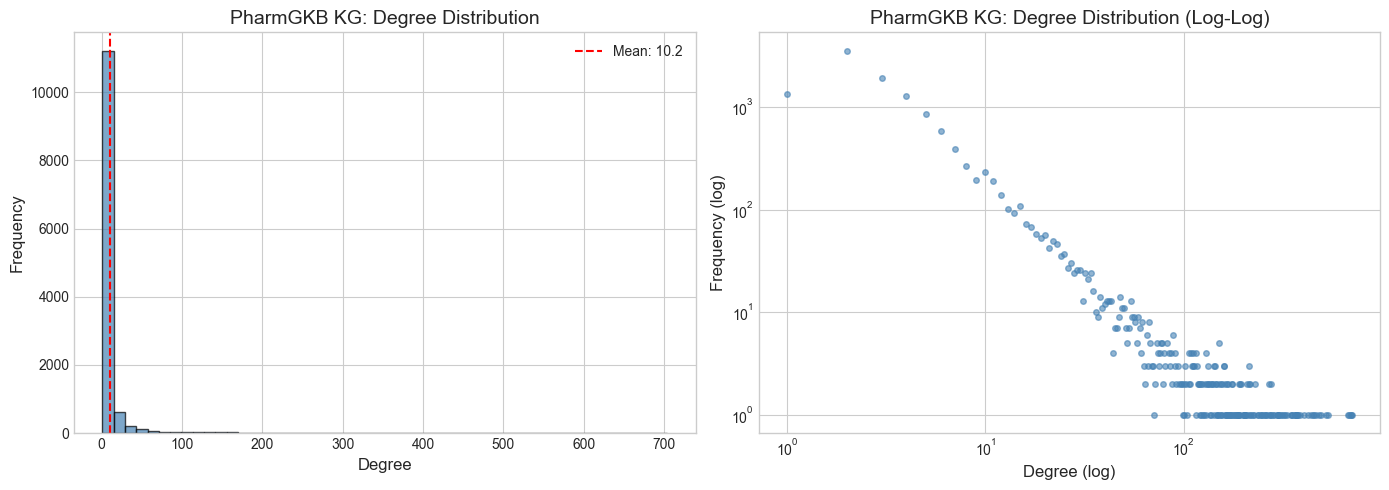

In [45]:
# Degree distribution (log-log plot to check for scale-free property)
if 'G' in dir():
    degrees = [d for n, d in G.degree()]
    degree_counts = Counter(degrees)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(degrees, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].set_xlabel('Degree', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('PharmGKB KG: Degree Distribution', fontsize=14)
    axes[0].axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
    axes[0].legend()
    
    # Log-log plot (power law check)
    deg_vals = sorted(degree_counts.keys())
    deg_freqs = [degree_counts[d] for d in deg_vals]
    
    axes[1].loglog(deg_vals, deg_freqs, 'o', markersize=4, alpha=0.6, color='steelblue')
    axes[1].set_xlabel('Degree (log)', fontsize=12)
    axes[1].set_ylabel('Frequency (log)', fontsize=12)
    axes[1].set_title('PharmGKB KG: Degree Distribution (Log-Log)', fontsize=14)
    
    plt.tight_layout()
    plt.show()

Creating sample subgraph visualization (gene-drug interactions)...
Subgraph: 50 nodes, 0 edges


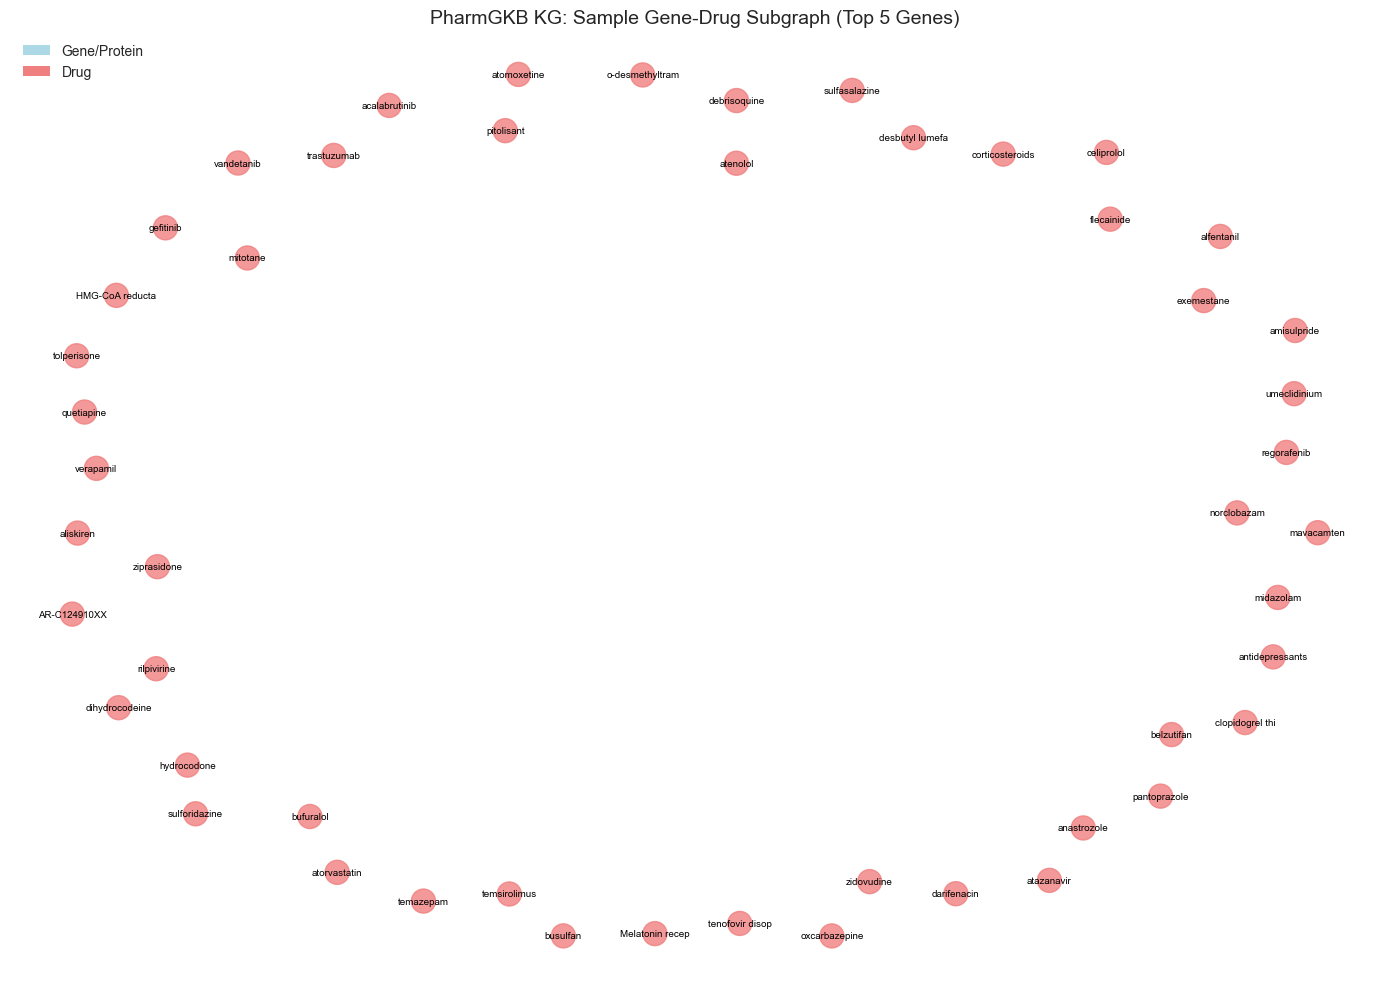

In [46]:
# Visualize a sample subgraph (gene-drug interactions)
if 'G' in dir():
    print("Creating sample subgraph visualization (gene-drug interactions)...")
    
    # Get top genes by degree
    gene_nodes = [(n, d) for n, d in G.degree() if G.nodes[n].get('node_type') == 'gene/protein']
    top_genes = sorted(gene_nodes, key=lambda x: x[1], reverse=True)[:5]
    
    # Build subgraph with these genes and their drug neighbors
    subgraph_nodes = set()
    for gene_node, _ in top_genes:
        subgraph_nodes.add(gene_node)
        for neighbor in G.neighbors(gene_node):
            if G.nodes[neighbor].get('node_type') == 'drug':
                subgraph_nodes.add(neighbor)
    
    # Limit to reasonable size
    subgraph_nodes = list(subgraph_nodes)[:50]
    subG = G.subgraph(subgraph_nodes)
    
    print(f"Subgraph: {subG.number_of_nodes()} nodes, {subG.number_of_edges()} edges")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Color by node type
    node_colors = []
    for node in subG.nodes():
        ntype = subG.nodes[node].get('node_type', 'unknown')
        if ntype == 'gene/protein':
            node_colors.append('lightblue')
        elif ntype == 'drug':
            node_colors.append('lightcoral')
        else:
            node_colors.append('lightgray')
    
    # Layout
    pos = nx.spring_layout(subG, k=2, iterations=50, seed=42)
    
    # Draw
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=300, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(subG, pos, alpha=0.4, ax=ax)
    
    # Labels (shortened)
    labels = {n: G.nodes[n].get('name', n)[:15] for n in subG.nodes()}
    nx.draw_networkx_labels(subG, pos, labels, font_size=7, ax=ax)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', label='Gene/Protein'),
        Patch(facecolor='lightcoral', label='Drug'),
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_title('PharmGKB KG: Sample Gene-Drug Subgraph (Top 5 Genes)', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

### 5.5 Export Knowledge Graph

Save the knowledge graph in formats ready for GNN integration.

In [47]:
# Export knowledge graph in PrimeKG-compatible format
if 'pharmgkb_kg' in dir():
    import pickle
    
    print("Exporting PharmGKB Knowledge Graph...")
    print("="*60)
    
    # 1. Export full KG as CSV (PrimeKG-compatible)
    kg_path = f"{DATA_DIR}/pharmgkb_kg.csv"
    pharmgkb_kg.to_csv(kg_path, index=False)
    print(f"Saved: {kg_path} ({len(pharmgkb_kg):,} edges)")
    
    # 2. Export node list
    nodes_data = []
    for node, data in G.nodes(data=True):
        nodes_data.append({
            'node_id': data.get('node_id', node),
            'node_name': data.get('name', ''),
            'node_type': data.get('node_type', 'unknown'),
            'node_key': node  # Full key for graph lookup
        })
    nodes_df = pd.DataFrame(nodes_data)
    nodes_path = f"{DATA_DIR}/pharmgkb_nodes.csv"
    nodes_df.to_csv(nodes_path, index=False)
    print(f"Saved: {nodes_path} ({len(nodes_df):,} nodes)")
    
    # 3. Export edge list
    edges_data = []
    for u, v, data in G.edges(data=True):
        edges_data.append({
            'source': u,
            'target': v,
            'relation': data.get('relation', ''),
            'evidence': data.get('evidence', ''),
            'source_db': data.get('source', 'PharmGKB')
        })
    edges_df = pd.DataFrame(edges_data)
    edges_path = f"{DATA_DIR}/pharmgkb_edges.csv"
    edges_df.to_csv(edges_path, index=False)
    print(f"Saved: {edges_path} ({len(edges_df):,} edges)")
    
    # 4. Export NetworkX graph as pickle
    graph_path = f"{DATA_DIR}/pharmgkb_graph.pkl"
    with open(graph_path, 'wb') as f:
        pickle.dump(G, f)
    print(f"Saved: {graph_path} (NetworkX graph object)")
    
    print("\n" + "="*60)
    print("EXPORT COMPLETE")
    print("="*60)

Exporting PharmGKB Knowledge Graph...
Saved: data/pharmgkb/pharmgkb_kg.csv (127,600 edges)
Saved: data/pharmgkb/pharmgkb_nodes.csv (12,528 nodes)
Saved: data/pharmgkb/pharmgkb_edges.csv (63,800 edges)
Saved: data/pharmgkb/pharmgkb_graph.pkl (NetworkX graph object)

EXPORT COMPLETE


## 6. Variant Annotations

Variant annotations provide study-level evidence for variant-drug associations.

In [48]:
# Load variant annotations
var_ann_file = glob.glob(f"{DATA_DIR}/var*ann*.tsv")
if not var_ann_file:
    var_ann_file = glob.glob(f"{DATA_DIR}/*variant*.tsv")

if var_ann_file:
    print(f"Loading: {var_ann_file[0]}")
    var_annotations = pd.read_csv(var_ann_file[0], sep='\t', low_memory=False)
    print(f"Loaded {len(var_annotations):,} variant annotations")
else:
    print("Variant annotations file not found.")
    var_annotations = pd.DataFrame()

Loading: data/pharmgkb/var_fa_ann.tsv
Loaded 2,122 variant annotations


In [49]:
# Explore variant annotations
if len(var_annotations) > 0:
    print("="*60)
    print("VARIANT ANNOTATIONS OVERVIEW")
    print("="*60)
    print(f"\nShape: {var_annotations.shape}")
    print(f"\nColumns: {list(var_annotations.columns)}")
    print(f"\nSample:")
    display(var_annotations.head(10))

VARIANT ANNOTATIONS OVERVIEW

Shape: (2122, 23)

Columns: ['Variant Annotation ID', 'Variant/Haplotypes', 'Gene', 'Drug(s)', 'PMID', 'Phenotype Category', 'Significance', 'Notes', 'Sentence', 'Alleles', 'Specialty Population', 'Assay type', 'Metabolizer types', 'isPlural', 'Is/Is Not associated', 'Direction of effect', 'Functional terms', 'Gene/gene product', 'When treated with/exposed to/when assayed with', 'Multiple drugs And/or', 'Cell type', 'Comparison Allele(s) or Genotype(s)', 'Comparison Metabolizer types']

Sample:


,Variant Annotation ID,Variant/Haplotypes,Gene,Drug(s),PMID,Phenotype Category,Significance,Notes,Sentence,Alleles,Specialty Population,Assay type,Metabolizer types,isPlural,Is/Is Not associated,Direction of effect,Functional terms,Gene/gene product,When treated with/exposed to/when assayed with,Multiple drugs And/or,Cell type,Comparison Allele(s) or Genotype(s),Comparison Metabolizer types
0,1451148445,"CYP2C19*1, CYP2C19*17",CYP2C19,normeperidine,30902024,NaN,not stated,"In other in vitro experiments, normeperidine formation was significantly correlated with CYP2C19...",CYP2C19 *17/*17 is associated with increased formation of normeperidine as compared to CYP2C19 *...,*17/*17,NaN,in human liver microsomes,NaN,Is,Associated with,increased,formation of,NaN,NaN,NaN,NaN,*1/*1 + *1/*17,NaN
1,1448281185,"CYP2B6*1, CYP2B6*6",CYP2B6,bupropion,27439448,Efficacy,yes,The ratio of hydroxybupropion versus bupropion (AUC_hyd/ AUC_bup) in terms of area under the tim...,CYP2B6 *1/*1 is associated with increased activity of CYP2B6 when assayed with bupropion as comp...,*1/*1,NaN,NaN,NaN,Is,Associated with,increased,activity of,CYP2B6,when assayed with,NaN,NaN,*1/*6,NaN
2,1447944475,"CYP2C9*1, CYP2C9*2",CYP2C9,warfarin,25823787,Metabolism/PK,not stated,CYP2C9*1 formed three hydrogen bonds with warfarin (two hydrogen bonds with protein backbone at ...,CYP2C9 *2 is associated with decreased affinity to CYP2C9 of warfarin as compared to CYP2C9 *1.,*2,NaN,crystal structure prediction,NaN,Is,Associated with,decreased,affinity to,CYP2C9,of,NaN,NaN,*1,NaN
3,1447944483,"CYP2C9*1, CYP2C9*3",CYP2C9,warfarin,25823787,Metabolism/PK,not stated,CYP2C9*1 formed three hydrogen bonds with warfarin (two hydrogen bonds with protein backbone at ...,CYP2C9 *3 is associated with decreased affinity to CYP2C9 of warfarin as compared to CYP2C9 *1.,*3,NaN,crystal structure prediction,NaN,Is,Associated with,decreased,affinity to,CYP2C9,of,NaN,NaN,*1,NaN
4,1451098400,rs72552763,SLC22A1,ranitidine,29236753,Metabolism/PK,yes,"as reported for OCT1*2, with Vmax decreased by more than 50%. This shows substrate-specific effe...",Allele del is associated with decreased transport of ranitidine as compared to allele GAT.,del,NaN,Cells,NaN,Is,Associated with,decreased,transport of,NaN,NaN,NaN,NaN,GAT,NaN
5,1450372418,"CYP2C19*1, CYP2C19*32",CYP2C19,voriconazole,30464555,Metabolism/PK,yes,Clearance was 26.57% of wild-type. CYP2C19 variants expressed in Sf21 insect cells using baculov...,CYP2C19 *32 is associated with decreased clearance of voriconazole as compared to CYP2C19 *1.,*32,NaN,NaN,NaN,Is,Associated with,decreased,clearance of,NaN,NaN,NaN,NaN,*1,NaN
6,1450372409,"CYP2C19*1, CYP2C19*31",CYP2C19,voriconazole,30464555,Metabolism/PK,yes,Clearance was 18.36% of wild-type. CYP2C19 variants expressed in Sf21 insect cells using baculov...,CYP2C19 *31 is associated with decreased clearance of voriconazole as compared to CYP2C19 *1.,*31,NaN,NaN,NaN,Is,Associated with,decreased,clearance of,NaN,NaN,NaN,NaN,*1,NaN
7,1450372400,"CYP2C19*1, CYP2C19*30",CYP2C19,voriconazole,30464555,Metabolism/PK,yes,Clearance was 12.17% of wild-type. CYP2C19 variants expressed in Sf21 insect cells using baculov...,CYP2C19 *30 is associated with decreased clearance of voriconazole as compared to CYP2C19 *1.,*30,NaN,NaN,NaN,Is,Associated with,decreased,clearance of,NaN,NaN,NaN,NaN,*1,NaN
8,1450377658,rs1349931378,CYP2C19,"mephenytoin, omeprazole",26153442,Metabolism/PK,yes,Relative omeprazole and S-mephenytoin hydroxylation activities of CYP2C19 variant proteins expre...,Allele A is associated with decreased activity of CYP2C19 when assayed with mephenytoin or omepr...,A,NaN,NaN,NaN,Is,Associated with,decreased,activity of,CYP2C19,when assayed with,or,in 293FT cells,G,NaN
9,1450372391,"CYP2C19*1, CYP2C19*29",CYP2C19,voriconazole,30464555,Metabolism/PK,yes,Clearance was 83.78% of wild-type. CYP2C19 variants expressed in Sf21 insect cells using baculov...,CYP2C19 *29 is associated with decreased clearance 

In [50]:
# Analyze variant types
if len(var_annotations) > 0:
    # Find variant column
    var_col = None
    for col in var_annotations.columns:
        if 'variant' in col.lower() and 'id' not in col.lower():
            var_col = col
            break
    
    if var_col:
        print(f"\nUnique variants: {var_annotations[var_col].nunique():,}")
        print(f"\nTop 20 most studied variants:")
        print(var_annotations[var_col].value_counts().head(20))


Unique variants: 1,325

Top 20 most studied variants:
Variant/Haplotypes
rs3918290                           17
CYP2D6*1, CYP2D6*10                 16
CYP2D6*1, CYP2D6*17                 12
CYP2C19*1, CYP2C19*19               12
rs1801159                           12
rs1801265                           11
CYP2C9*1, CYP2C9*3                  10
CYP2C19*1, CYP2C19*10               10
CYP2D6*1, CYP2D6*2                  10
CYP2C19*1, CYP2C19*18               10
rs2108622                           10
rs2229109                           10
TPMT*1, TPMT*3A                      9
rs55886062                           9
rs72552784                           9
rs9282564                            9
TPMT*1, TPMT*2, TPMT*3A, TPMT*3C     8
rs67376798                           8
CYP3A5*1, CYP3A5*3                   8
rs2297595                            8
Name: count, dtype: int64


In [51]:
# Significance analysis
if len(var_annotations) > 0:
    # Find significance/p-value column
    sig_cols = [col for col in var_annotations.columns 
               if 'significance' in col.lower() or 'p-value' in col.lower() or 'pvalue' in col.lower()]
    
    print("\nSignificance-related columns:")
    for col in sig_cols:
        print(f"\n{col}:")
        print(var_annotations[col].value_counts().head(10))


Significance-related columns:

Significance:
Significance
yes           1103
not stated     617
no             402
Name: count, dtype: int64


## 7. Drug Labels

FDA-approved pharmacogenomic information in drug labels.

In [52]:
# Load drug labels
label_file = glob.glob(f"{DATA_DIR}/drug*label*.tsv")
if not label_file:
    label_file = glob.glob(f"{DATA_DIR}/*label*.tsv")

if label_file:
    print(f"Loading: {label_file[0]}")
    drug_labels = pd.read_csv(label_file[0], sep='\t', low_memory=False)
    print(f"Loaded {len(drug_labels):,} drug label entries")
else:
    print("Drug labels file not found.")
    drug_labels = pd.DataFrame()

Drug labels file not found.


In [53]:
# Explore drug labels
if len(drug_labels) > 0:
    print("="*60)
    print("DRUG LABELS OVERVIEW")
    print("="*60)
    print(f"\nShape: {drug_labels.shape}")
    print(f"\nColumns: {list(drug_labels.columns)}")
    print(f"\nSample:")
    display(drug_labels.head(10))

In [54]:
# Analyze label sources and testing levels
if len(drug_labels) > 0:
    for col in drug_labels.columns:
        if drug_labels[col].dtype == 'object' and drug_labels[col].nunique() < 50:
            print(f"\n{col}:")
            print(drug_labels[col].value_counts())

In [55]:
# Drugs requiring genetic testing
if len(drug_labels) > 0:
    # Find testing requirement column
    test_cols = [col for col in drug_labels.columns 
                if 'testing' in col.lower() or 'required' in col.lower() or 'actionable' in col.lower()]
    
    if test_cols:
        print("\nGenetic testing requirements:")
        for col in test_cols:
            print(f"\n{col}:")
            print(drug_labels[col].value_counts())

## 8. Pathway Analysis

PharmGKB pathways show drug mechanisms through gene/protein networks.

In [56]:
# Check for pathway files
pathway_dir = f"{DATA_DIR}/pathways"
pathway_files = glob.glob(f"{pathway_dir}/*.tsv") + glob.glob(f"{DATA_DIR}/*pathway*.tsv")

print(f"Found {len(pathway_files)} pathway files")
for pf in pathway_files[:10]:
    print(f"  {os.path.basename(pf)}")

Found 0 pathway files


In [57]:
# Load and analyze pathway files if available
if pathway_files:
    print("\nSample pathway file structure:")
    sample_pathway = pd.read_csv(pathway_files[0], sep='\t', low_memory=False)
    print(f"\nShape: {sample_pathway.shape}")
    print(f"Columns: {list(sample_pathway.columns)}")
    display(sample_pathway.head(10))

In [58]:
# Build drug-pathway network from available data
# Note: PharmGKB pathways may need to be downloaded individually
print("""
For comprehensive pathway analysis, download pathway files from:
https://www.pharmgkb.org/pathways

Each pathway has:
- TSV format: gene-drug-pathway relationships
- BioPAX format: structured pathway data
- GPML format: GenMAPP Pathway Markup Language

Key pathways for ADR research:
- Drug metabolism pathways (CYP enzymes)
- Drug transport pathways (ABC transporters)
- Pharmacodynamic pathways (drug targets)
""")


For comprehensive pathway analysis, download pathway files from:
https://www.pharmgkb.org/pathways

Each pathway has:
- TSV format: gene-drug-pathway relationships
- BioPAX format: structured pathway data
- GPML format: GenMAPP Pathway Markup Language

Key pathways for ADR research:
- Drug metabolism pathways (CYP enzymes)
- Drug transport pathways (ABC transporters)
- Pharmacodynamic pathways (drug targets)



## 9. Toxicity & ADR Deep Dive

Focus on adverse drug reaction-related annotations for our research question.

In [59]:
# Filter clinical annotations for toxicity phenotypes
if len(clinical_ann) > 0:
    print("="*60)
    print("TOXICITY / ADVERSE DRUG REACTION ANALYSIS")
    print("="*60)
    
    # Find phenotype category column
    phenotype_col = None
    for col in clinical_ann.columns:
        if 'phenotype' in col.lower() and 'category' in col.lower():
            phenotype_col = col
            break
        elif 'phenotype' in col.lower():
            phenotype_col = col
    
    if phenotype_col:
        # Filter for toxicity
        toxicity_mask = clinical_ann[phenotype_col].str.contains('toxicity|adverse|side effect', 
                                                                  case=False, na=False)
        toxicity_ann = clinical_ann[toxicity_mask]
        
        print(f"\nToxicity-related annotations: {len(toxicity_ann):,}")
        print(f"Percentage of all annotations: {100*len(toxicity_ann)/len(clinical_ann):.1f}%")
    else:
        # Try text search in all object columns
        toxicity_keywords = ['toxicity', 'adverse', 'side effect', 'toxic']
        toxicity_mask = pd.Series([False] * len(clinical_ann))
        
        for col in clinical_ann.select_dtypes(include=['object']).columns:
            for keyword in toxicity_keywords:
                toxicity_mask |= clinical_ann[col].str.contains(keyword, case=False, na=False)
        
        toxicity_ann = clinical_ann[toxicity_mask]
        print(f"\nToxicity-related annotations (keyword search): {len(toxicity_ann):,}")

TOXICITY / ADVERSE DRUG REACTION ANALYSIS

Toxicity-related annotations (keyword search): 65


/var/folders/8b/247_9l2j1zjddy4x74jqqhb80000gn/T/ipykernel_62789/2076485309.py:29: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in clinical_ann.select_dtypes(include=['object']).columns:


In [60]:
# Genes most associated with adverse reactions
if 'toxicity_ann' in dir() and len(toxicity_ann) > 0:
    gene_col = None
    for col in toxicity_ann.columns:
        if 'gene' in col.lower() and 'id' not in col.lower():
            gene_col = col
            break
    
    if gene_col:
        print("\nTop genes associated with toxicity/adverse reactions:")
        tox_gene_counts = toxicity_ann[gene_col].value_counts().head(20)
        print(tox_gene_counts)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        tox_gene_counts.plot(kind='bar', ax=ax, color='red', alpha=0.7)
        ax.set_xlabel('Gene', fontsize=12)
        ax.set_ylabel('Number of Toxicity Annotations', fontsize=12)
        ax.set_title('Genes Most Associated with Drug Toxicity', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [61]:
# Drugs most associated with toxicity annotations
if 'toxicity_ann' in dir() and len(toxicity_ann) > 0:
    drug_col = None
    for col in toxicity_ann.columns:
        if 'drug' in col.lower() or 'chemical' in col.lower():
            if 'id' not in col.lower():
                drug_col = col
                break
    
    if drug_col:
        print("\nTop drugs with toxicity annotations:")
        tox_drug_counts = toxicity_ann[drug_col].value_counts().head(20)
        print(tox_drug_counts)

In [62]:
# Create ADR-focused subgraph data
if 'toxicity_ann' in dir() and len(toxicity_ann) > 0:
    print("\n" + "="*60)
    print("ADR SUBGRAPH SUMMARY")
    print("="*60)
    
    # Get unique entities
    summary = {}
    for col in toxicity_ann.columns:
        if any(x in col.lower() for x in ['gene', 'drug', 'variant', 'chemical']):
            if 'id' not in col.lower():
                summary[col] = toxicity_ann[col].nunique()
    
    print("\nUnique entities in toxicity annotations:")
    for k, v in summary.items():
        print(f"  {k}: {v:,}")


ADR SUBGRAPH SUMMARY

Unique entities in toxicity annotations:


## 10. PrimeKG Integration Check

Check overlap with PrimeKG for building unified knowledge graph.

In [63]:
# Load PrimeKG drug data if available
primekg_path = 'data/kg.csv'

if os.path.exists(primekg_path):
    print("Loading PrimeKG for integration check...")
    primekg = pd.read_csv(primekg_path, low_memory=False)
    
    # Get unique drugs from PrimeKG
    primekg_drugs_x = set(primekg[primekg['x_type'] == 'drug']['x_name'].unique())
    primekg_drugs_y = set(primekg[primekg['y_type'] == 'drug']['y_name'].unique())
    primekg_drugs = primekg_drugs_x.union(primekg_drugs_y)
    
    # Get unique genes from PrimeKG
    primekg_genes_x = set(primekg[primekg['x_type'] == 'gene/protein']['x_name'].unique())
    primekg_genes_y = set(primekg[primekg['y_type'] == 'gene/protein']['y_name'].unique())
    primekg_genes = primekg_genes_x.union(primekg_genes_y)
    
    print(f"\nPrimeKG entities:")
    print(f"  Drugs: {len(primekg_drugs):,}")
    print(f"  Genes: {len(primekg_genes):,}")
else:
    print("PrimeKG not found. Run explore_primekg.ipynb first to download.")
    primekg_drugs = set()
    primekg_genes = set()

Loading PrimeKG for integration check...

PrimeKG entities:
  Drugs: 7,957
  Genes: 27,671


In [ ]:
# Check drug overlap
if len(primekg_drugs) > 0 and len(clinical_ann) > 0:
    # Get PharmGKB drugs
    drug_col = None
    for col in clinical_ann.columns:
        if 'drug' in col.lower() or 'chemical' in col.lower():
            if 'id' not in col.lower():
                drug_col = col
                break

    if drug_col:
        pharmgkb_drugs = set(clinical_ann[drug_col].dropna().unique())
        
        # Normalize names for comparison (lowercase, strip)
        primekg_drugs_norm = {d.lower().strip() for d in primekg_drugs if pd.notna(d)}
        pharmgkb_drugs_norm = {d.lower().strip() for d in pharmgkb_drugs if pd.notna(d)}
        
        overlap = primekg_drugs_norm.intersection(pharmgkb_drugs_norm)
        
        print("\n" + "="*60)
        print("PRIMEKG - PHARMGKB INTEGRATION")
        print("="*60)
        print(f"\nDrug overlap:")
        print(f"  PrimeKG drugs: {len(primekg_drugs_norm):,}")
        print(f"  PharmGKB drugs: {len(pharmgkb_drugs_norm):,}")
        print(f"  Overlapping drugs: {len(overlap):,}")
        print(f"  Overlap percentage: {100*len(overlap)/min(len(primekg_drugs_norm), len(pharmgkb_drugs_norm)):.1f}%")
        
        print(f"\nSample overlapping drugs:")
        print(list(overlap)[:20])

       Clinical Annotation ID Date (YYYY-MM-DD)    Type  \
0                   655384602        2018-11-05  Update   
1                   655384602        2021-03-24  Update   
2                   655384607        2018-11-05  Update   
3                   655384607        2021-03-24  Update   
4                   655384626        2018-11-05  Update   
...                       ...               ...     ...   
14025              1452862380        2025-02-28  Create   
14026              1452869100        2025-03-06  Create   
14027              1452869120        2025-03-06  Create   
14028              1452872961        2025-03-10  Create   
14029              1452877100        2025-03-12  Create   

                                                                                                   Comment  
0                                                    Updated OMB race to appropriate biogeographical group  
1      CA score added as part of scoring system release. LOE may have aut

In [ ]:
# Check gene overlap
if len(primekg_genes) > 0 and len(clinical_ann) > 0:
    gene_col = None
    for col in clinical_ann.columns:
        if 'gene' in col.lower() and 'id' not in col.lower():
            gene_col = col
            break
    
    if gene_col:
        pharmgkb_genes = set(clinical_ann[gene_col].dropna().unique())
        
        # Normalize names
        primekg_genes_norm = {g.upper().strip() for g in primekg_genes if pd.notna(g)}
        pharmgkb_genes_norm = {g.upper().strip() for g in pharmgkb_genes if pd.notna(g)}
        
        gene_overlap = primekg_genes_norm.intersection(pharmgkb_genes_norm)
        
        print(f"\nGene overlap:")
        print(f"  PrimeKG genes: {len(primekg_genes_norm):,}")
        print(f"  PharmGKB genes: {len(pharmgkb_genes_norm):,}")
        print(f"  Overlapping genes: {len(gene_overlap):,}")
        print(f"  Overlap percentage: {100*len(gene_overlap)/min(len(primekg_genes_norm), len(pharmgkb_genes_norm)):.1f}%")

## 11. Summary & Export for GNN

In [ ]:
print("="*60)
print("PHARMGKB EXPLORATION SUMMARY")
print("="*60)

summary_data = []

if len(clinical_ann) > 0:
    summary_data.append(['Clinical Annotations', f"{len(clinical_ann):,}"])
    
if len(relationships) > 0:
    summary_data.append(['Relationships', f"{len(relationships):,}"])
    
if len(var_annotations) > 0:
    summary_data.append(['Variant Annotations', f"{len(var_annotations):,}"])
    
if len(drug_labels) > 0:
    summary_data.append(['Drug Labels', f"{len(drug_labels):,}"])
    
if 'toxicity_ann' in dir() and len(toxicity_ann) > 0:
    summary_data.append(['Toxicity Annotations', f"{len(toxicity_ann):,}"])
    
if 'overlap' in dir():
    summary_data.append(['Drug Overlap with PrimeKG', f"{len(overlap):,}"])
    
if 'gene_overlap' in dir():
    summary_data.append(['Gene Overlap with PrimeKG', f"{len(gene_overlap):,}"])

summary_df = pd.DataFrame(summary_data, columns=['Metric', 'Value'])
print(summary_df.to_string(index=False))

In [ ]:
# Export filtered datasets for GNN work
print("\nExporting datasets for GNN work...")

# Export toxicity annotations
if 'toxicity_ann' in dir() and len(toxicity_ann) > 0:
    toxicity_ann.to_csv(f'{DATA_DIR}/toxicity_annotations.csv', index=False)
    print(f"Saved: {DATA_DIR}/toxicity_annotations.csv ({len(toxicity_ann):,} rows)")

# Export high-evidence clinical annotations
if len(clinical_ann) > 0:
    evidence_col = None
    for col in clinical_ann.columns:
        if 'level' in col.lower() or 'evidence' in col.lower():
            evidence_col = col
            break
    
    if evidence_col:
        # Filter for high evidence (1A, 1B, 2A)
        high_evidence = clinical_ann[clinical_ann[evidence_col].isin(['1A', '1B', '2A'])]
        if len(high_evidence) > 0:
            high_evidence.to_csv(f'{DATA_DIR}/high_evidence_annotations.csv', index=False)
            print(f"Saved: {DATA_DIR}/high_evidence_annotations.csv ({len(high_evidence):,} rows)")

# Export gene-drug relationships
if 'gene_drug_rels' in dir() and len(gene_drug_rels) > 0:
    gene_drug_rels.to_csv(f'{DATA_DIR}/gene_drug_relationships.csv', index=False)
    print(f"Saved: {DATA_DIR}/gene_drug_relationships.csv ({len(gene_drug_rels):,} rows)")

In [ ]:
print("""
========================================
KEY FINDINGS & NEXT STEPS FOR GNN
========================================

1. PHARMGKB DATA RELEVANCE:
   - Clinical annotations link genetic variants to drug response phenotypes
   - Toxicity phenotype category directly relevant to ADR prediction
   - Evidence levels allow filtering for high-confidence associations
   - Gene-drug relationships provide mechanistic insights

2. INTEGRATION WITH PRIMEKG:
   - Significant drug and gene overlap enables knowledge graph fusion
   - PrimeKG provides drug-disease edges
   - PharmGKB provides gene-drug-phenotype edges
   - Combined: drug -> gene -> pathway -> disease connections

3. GNN MODEL CONSIDERATIONS:
   - Heterogeneous graph with multiple node types:
     * Drugs, Genes, Variants, Diseases, Pathways
   - Multiple edge types:
     * drug-gene associations, gene-pathway membership,
     * drug-disease (indication/contraindication), gene-disease
   - Phenotype labels for supervised learning:
     * Toxicity vs non-toxicity as binary classification
     * Multi-class: Toxicity, Efficacy, Dosage, PK, PD

4. RESEARCH QUESTION APPROACH:
   "Can we predict adverse drug outcomes by modeling drug-affected 
    pathways interacting with disease-perturbed pathways?"
   
   Strategy:
   a) Build heterogeneous graph from PrimeKG + PharmGKB
   b) Use GNN to learn pathway embeddings
   c) Model drug-pathway and disease-pathway interactions
   d) Predict toxicity/ADR based on pathway overlap/conflict

5. EXPORTED FILES FOR GNN:
   - toxicity_annotations.csv: ADR-focused training data
   - high_evidence_annotations.csv: High-confidence edges
   - gene_drug_relationships.csv: Gene-drug network

Next notebook: Build and train GNN on combined knowledge graph
""")

print("\nPharmGKB exploration complete!")